This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-08 17:19:49--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.193.160, 54.231.229.168, 54.231.228.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.193.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  15.2MB/s    in 0.9s    

2023-11-08 17:19:51 (15.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

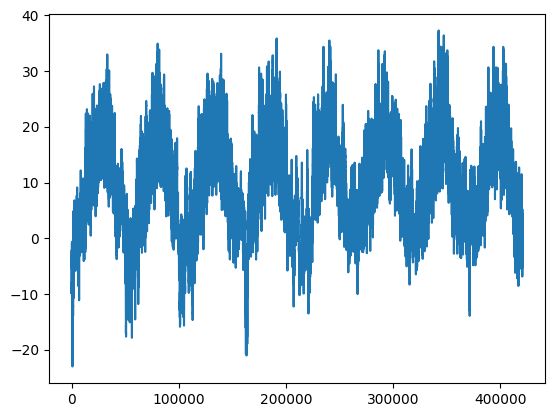

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

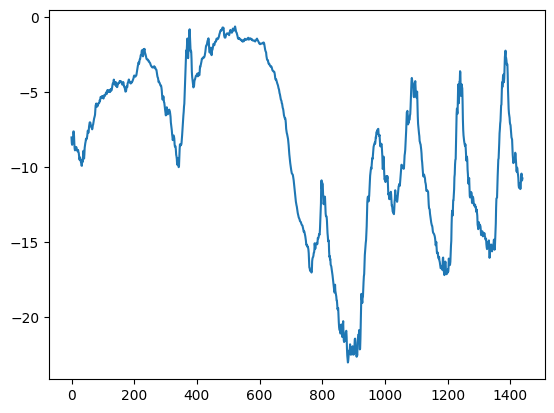

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 16ms/step - loss: 13.8832 - mae: 2.8814 - val_loss: 10.3290 - val_mae: 2.5416
Epoch 2/10
  7/819 [..............................] - ETA: 7s - loss: 10.2253 - mae: 2.5338 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 12s 15ms/step - loss: 9.6141 - mae: 2.4453 - val_loss: 10.3396 - val_mae: 2.5439
Epoch 3/10
819/819 [==============================] - 13s 15ms/step - loss: 8.8883 - mae: 2.3510 - val_loss: 12.9847 - val_mae: 2.8624
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 8.4512 - mae: 2.2912 - val_loss: 9.9913 - val_mae: 2.4963
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 8.1355 - mae: 2.2443 - val_loss: 10.2758 - val_mae: 2.5424
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.9218 - mae: 2.2161 - val_loss: 12.3672 - val_mae: 2.7863
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 7.7193 - mae: 2.1884 - val_loss: 10.6164 - val_mae: 2.5944
Epoch 8/10
819/819 [==============================] - 12s 15ms/step - loss: 7.5473 - mae: 2.1651 - val_loss: 12.3597 - val_mae: 2.7968
Epoch 9/10
819/819 [==============================] - 12s 15ms/step

**Plotting results**

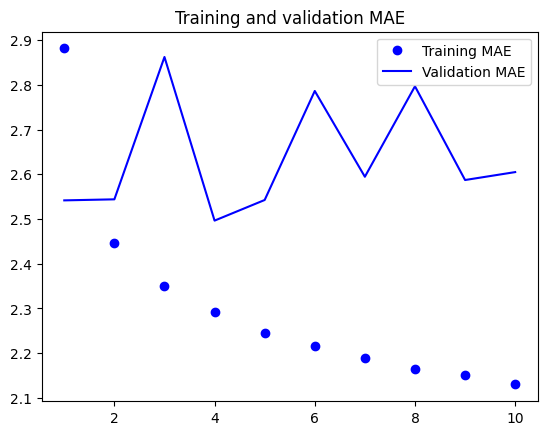

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 16ms/step - loss: 22.0236 - mae: 3.6575 - val_loss: 15.4922 - val_mae: 3.1137
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 15.4242 - mae: 3.1164 - val_loss: 14.8087 - val_mae: 3.0255
Epoch 3/10
819/819 [==============================] - 13s 15ms/step - loss: 14.4038 - mae: 3.0080 - val_loss: 15.2422 - val_mae: 3.0583
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 13.7001 - mae: 2.9295 - val_loss: 17.3832 - val_mae: 3.3316
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 13.1605 - mae: 2.8681 - val_loss: 17.6377 - val_mae: 3.2853
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 12.6869 - mae: 2.8162 - val_loss: 19.1201 - val_mae: 3.4571
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 12.2932 - mae: 2.7700 - val_loss: 16.8430 - val_mae: 3.1946
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 46.0732 - mae: 4.9709 - val_loss: 13.6668 - val_mae: 2.7866
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 11.0400 - mae: 2.5887 - val_loss: 9.8375 - val_mae: 2.4385
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 9.8521 - mae: 2.4591 - val_loss: 9.8186 - val_mae: 2.4375
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.4991 - mae: 2.4115 - val_loss: 9.8704 - val_mae: 2.4470
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 9.1818 - mae: 2.3660 - val_loss: 9.9660 - val_mae: 2.4505
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 8.8915 - mae: 2.3280 - val_loss: 9.7503 - val_mae: 2.4133
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.6316 - mae: 2.2943 - val_loss: 9.9532 - val_mae: 2.4429
Epoch 8/10
819/819 [==============================] - 13s 1

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 246s 297ms/step - loss: 29.3833 - mae: 3.9908 - val_loss: 9.8078 - val_mae: 2.4187
Epoch 2/50
819/819 [==============================] - 243s 297ms/step - loss: 14.9251 - mae: 3.0000 - val_loss: 9.8194 - val_mae: 2.4311
Epoch 3/50
819/819 [==============================] - 247s 302ms/step - loss: 13.9301 - mae: 2.8960 - val_loss: 9.7635 - val_mae: 2.4227
Epoch 4/50
819/819 [==============================] - 248s 302ms/step - loss: 13.2608 - mae: 2.8267 - val_loss: 9.9642 - val_mae: 2.4562
Epoch 5/50
819/819 [==============================] - 248s 303ms/step - loss: 12.8092 - mae: 2.7795 - val_loss: 9.8472 - val_mae: 2.4442
Epoch 6/50
819/819 [==============================] - 243s 297ms/step - loss: 12.4742 - mae: 2.7404 - val_loss: 9.9939 - val_mae: 2.4592
Epoch 7/50
819/819 [==============================] - 244s 298ms/step - loss: 12.1469 - mae: 2.7047 - val_loss: 10.0195 - val_mae: 2.4630
Epoch 8/50
819/819 [====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 479s 580ms/step - loss: 25.9096 - mae: 3.7414 - val_loss: 9.8531 - val_mae: 2.4285
Epoch 2/50
819/819 [==============================] - 473s 577ms/step - loss: 13.9063 - mae: 2.8904 - val_loss: 9.4887 - val_mae: 2.3892
Epoch 3/50
819/819 [==============================] - 470s 573ms/step - loss: 13.1256 - mae: 2.8060 - val_loss: 9.1155 - val_mae: 2.3581
Epoch 4/50
819/819 [==============================] - 471s 574ms/step - loss: 12.5392 - mae: 2.7478 - val_loss: 9.5945 - val_mae: 2.4045
Epoch 5/50
819/819 [==============================] - 469s 573ms/step - loss: 12.0279 - mae: 2.6910 - val_loss: 9.9663 - val_mae: 2.4582
Epoch 6/50
819/819 [==============================] - 466s 569ms/step - loss: 11.5978 - mae: 2.6472 - val_loss: 8.8448 - val_mae: 2.3128
Epoch 7/50
819/819 [==============================] - 467s 570ms/step - loss: 11.1888 - mae: 2.5987 - val_loss: 9.4415 - val_mae: 2.3940
Epoch 8/50
819/819 [=====================

405/405 [==============================] - 27s 64ms/step - loss: 9.3585 - mae: 2.3913
Test MAE: 2.39


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 27.1554 - mae: 3.7344 - val_loss: 10.4982 - val_mae: 2.5041
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.4946 - mae: 2.4110 - val_loss: 9.6690 - val_mae: 2.4053
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.6861 - mae: 2.2956 - val_loss: 9.3495 - val_mae: 2.3661
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.1809 - mae: 2.2263 - val_loss: 9.8588 - val_mae: 2.4320
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.8073 - mae: 2.1755 - val_loss: 9.5247 - val_mae: 2.3881
Epoch 6/10
819/819 [==============================] - 14s 18ms/step - loss: 7.4278 - mae: 2.1212 - val_loss: 9.5766 - val_mae: 2.3818
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.1817 - mae: 2.0888 - val_loss: 9.8783 - val_mae: 2.4390
Epoch 8/10
819/819 [==============================] - 15s 18

### Going even further

## Summary